In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, losses, optimizers, applications
import pathlib
import matplotlib.pyplot as plt

In [2]:
path = pathlib.Path("./assets/crop")

print("Required libraries imported")

Required libraries imported


In [3]:
train = image_dataset_from_directory(path, image_size=(128,128), validation_split=0.3, subset="training", shuffle=True, batch_size=25, seed=3)
validation = image_dataset_from_directory(path, image_size=(128,128), validation_split=0.3, subset="validation", shuffle=True, batch_size=25, seed=3)

Found 18822 files belonging to 43 classes.
Using 13176 files for training.
Found 18822 files belonging to 43 classes.
Using 5646 files for validation.


In [4]:
train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
validation

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
print(len(train))
print(len(validation))

528
226


In [7]:
batch = tf.data.experimental.cardinality(validation)
validation

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
test_b = validation.take(batch // 5)
validation_b = validation.skip(batch // 5)


In [9]:
test_b

<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
classes = train.class_names
classes

['A10',
 'A400M',
 'AG600',
 'AV8B',
 'B1',
 'B2',
 'B52',
 'Be200',
 'C130',
 'C17',
 'C2',
 'C5',
 'E2',
 'E7',
 'EF2000',
 'F117',
 'F14',
 'F15',
 'F16',
 'F18',
 'F22',
 'F35',
 'F4',
 'J20',
 'JAS39',
 'MQ9',
 'Mig31',
 'Mirage2000',
 'P3',
 'RQ4',
 'Rafale',
 'SR71',
 'Su34',
 'Su57',
 'Tornado',
 'Tu160',
 'Tu95',
 'U2',
 'US2',
 'V22',
 'Vulcan',
 'XB70',
 'YF23']

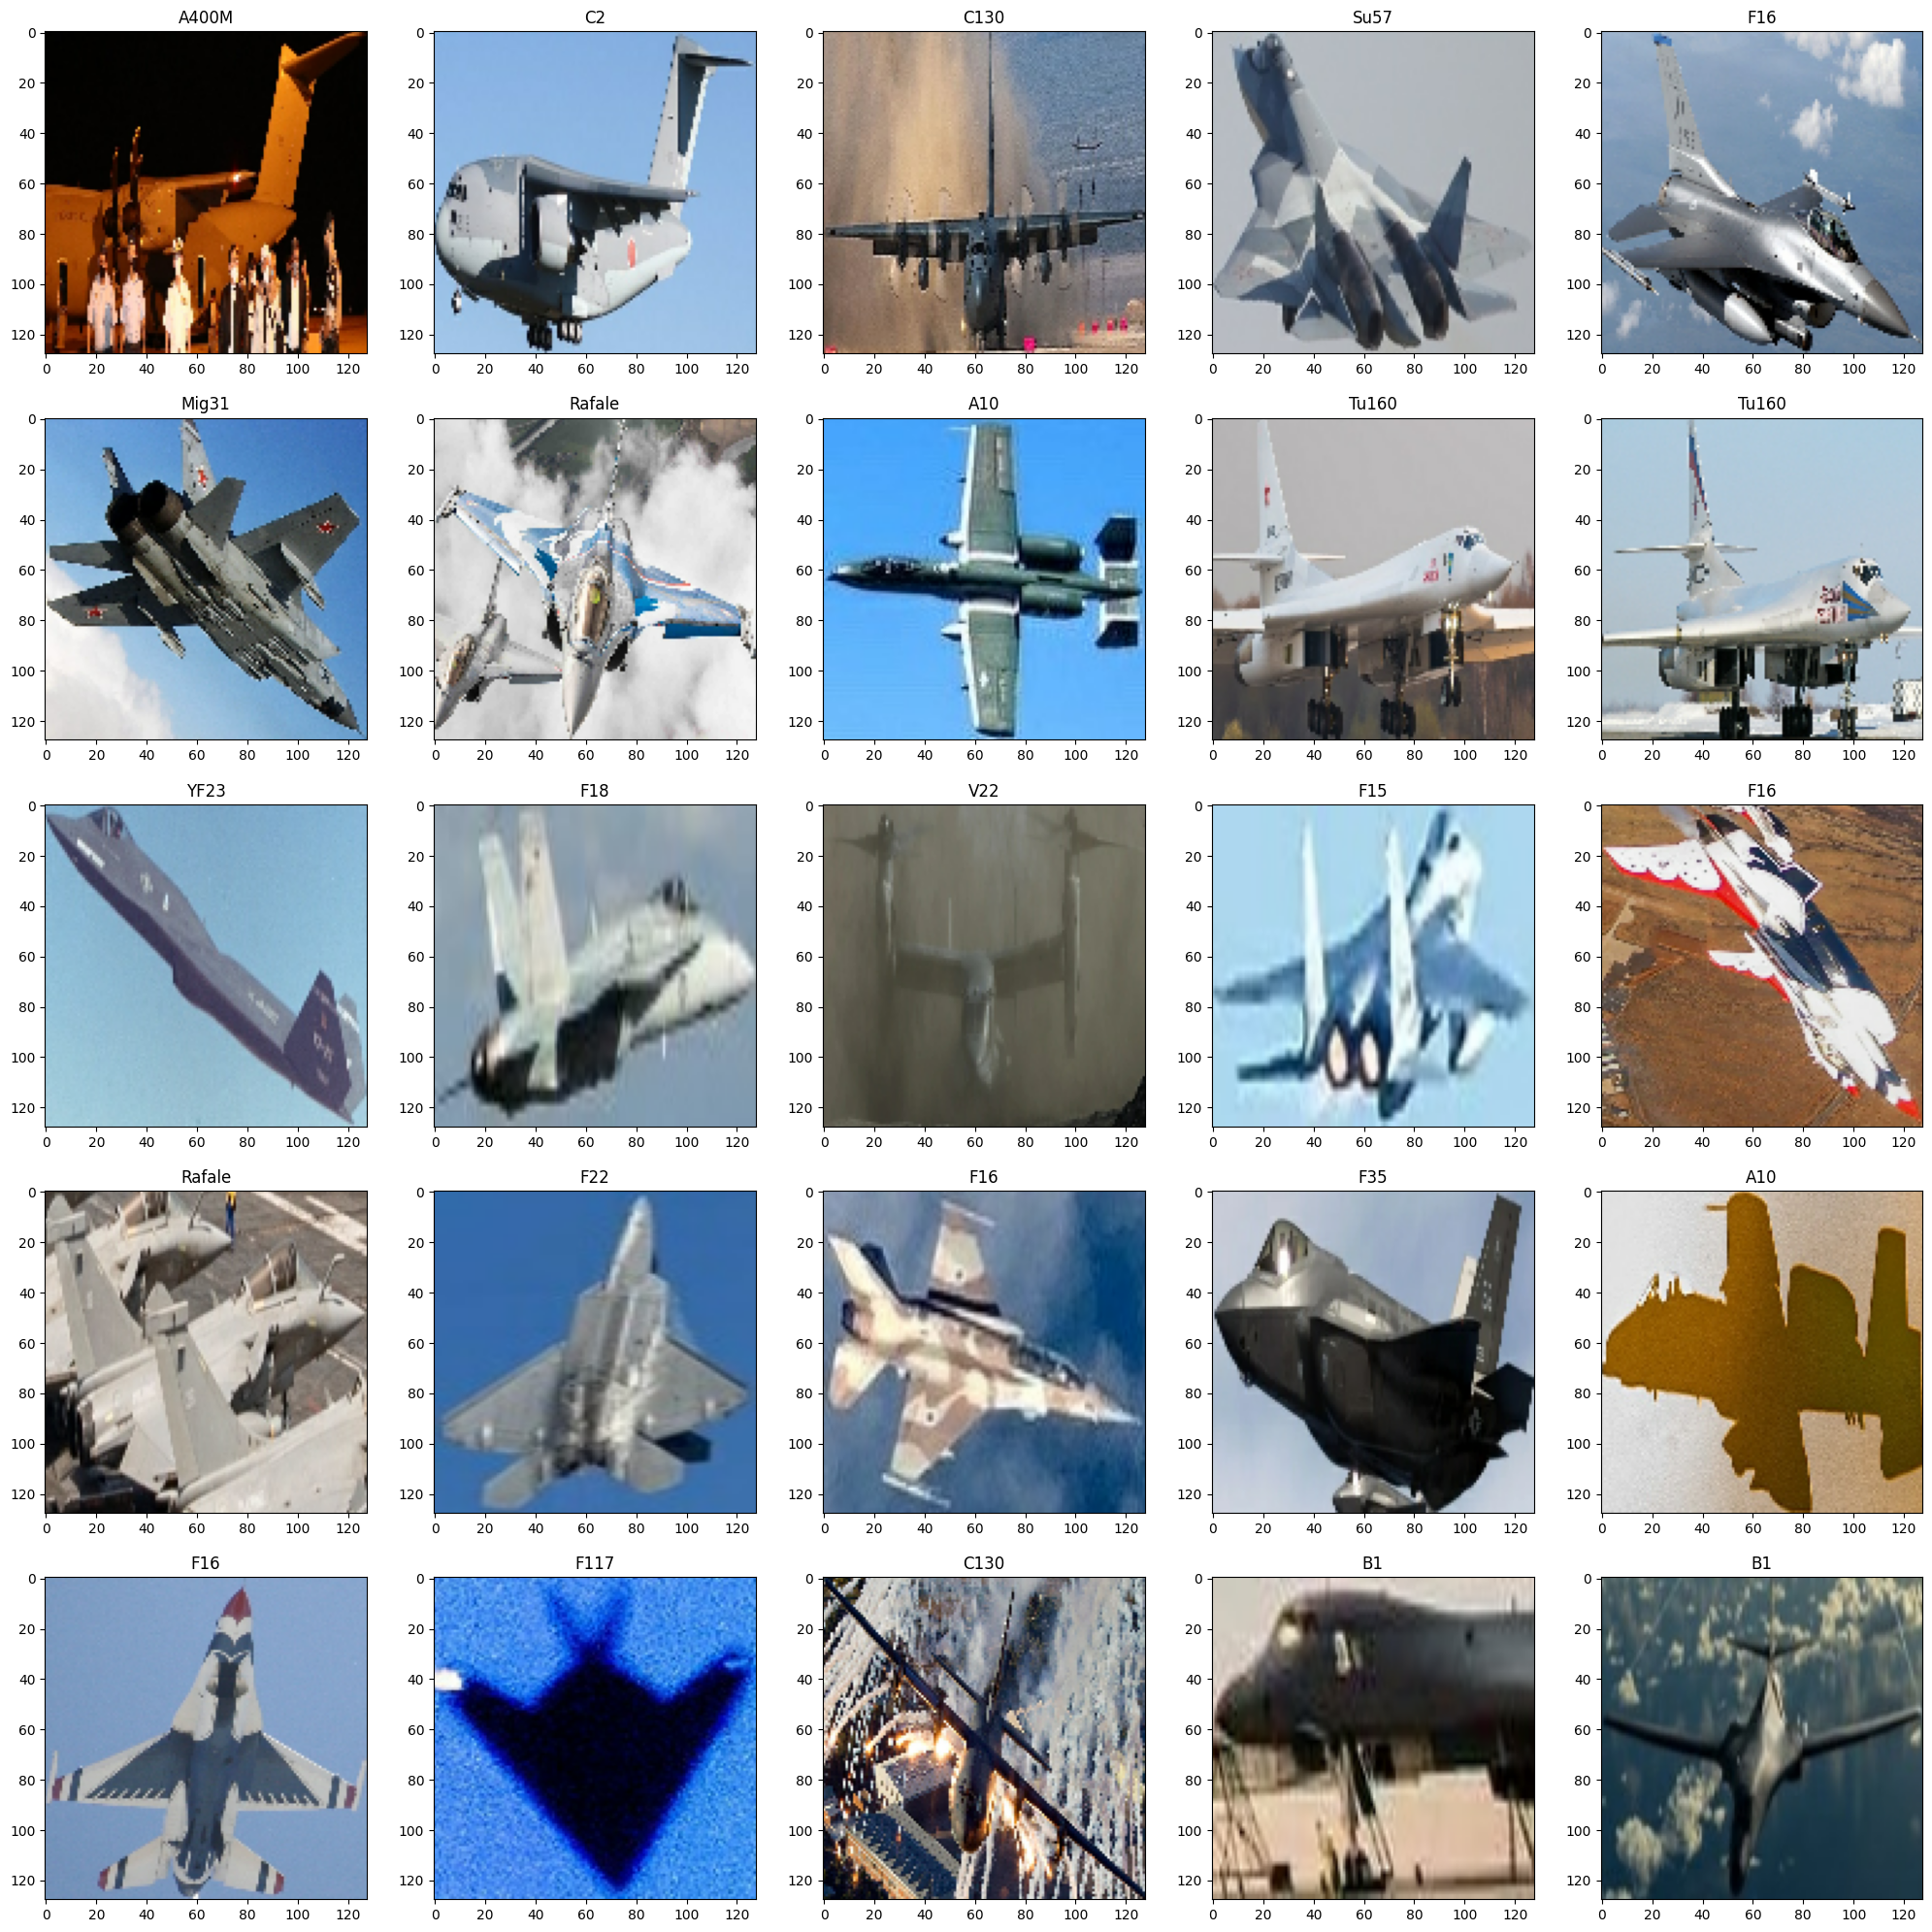

In [11]:
plt.figure(figsize=(25,25))
for images, labels in train.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])

In [12]:
auto = tf.data.AUTOTUNE
pre_train = train.prefetch(buffer_size=auto)
pre_test = test_b.prefetch(buffer_size=auto)
pre_val = validation_b.prefetch(buffer_size=auto)

In [13]:
aug = tf.keras.Sequential()
aug.add(layers.RandomRotation(0.3))
aug.add(layers.RandomFlip("horizontal_and_vertical"))

In [14]:
preprocess = applications.resnet50.preprocess_input

In [15]:
base_model = applications.ResNet50(input_shape=(128,128,3), include_top=False, weights="imagenet")

In [16]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [17]:
output_layer = layers.Dense(len(classes), activation="softmax")
global_avg = layers.GlobalAveragePooling2D()

In [18]:
img_shape = (128,128) + (3,)
inputs = tf.keras.Input(shape = img_shape)
x = aug(inputs)
x = preprocess(inputs)
x = base_model(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 128, 128, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 128, 128, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [19]:
optimizer = optimizers.Adam(learning_rate=0.01)
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss = loss, metrics=["accuracy"])

In [20]:
print(pre_train)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [21]:
history = model.fit(pre_train, validation_data=(pre_val), epochs=1)

528/528 [==============================] - 408s 766ms/step - loss: 10.4997 - accuracy: 0.2920 - val_loss: 10.2932 - val_accuracy: 0.3678


In [22]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [24]:
optimizer = optimizers.RMSprop(learning_rate = optimizers.schedules.CosineDecay(0.001, 500))
model.compile(optimizer = optimizer, loss = loss, metrics =["accuracy"])

In [25]:
history_finetuned = model.fit(pre_train, validation_data = (pre_val), epochs = 2, initial_epoch=history.epoch[-1])

Epoch 1/2
528/528 [==============================] - 985s 2s/step - loss: 2.1864 - accuracy: 0.5535 - val_loss: 1.0205 - val_accuracy: 0.7189
Epoch 2/2
528/528 [==============================] - 973s 2s/step - loss: 0.3775 - accuracy: 0.9135 - val_loss: 0.9932 - val_accuracy: 0.7235


In [90]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(patience=2)
callback = ModelCheckpoint(filepath="checkpoint_2", save_weights_only=True, monitor="val_accuracy", mode="max", save_best_only=True)

In [91]:
history_fin = model.fit(pre_train, validation_data=(pre_val), epochs=10, callbacks=[es, callback], use_multiprocessing=True, steps_per_epoch=50, validation_steps=50)

Epoch 1/10
50/50 [==============================] - 112s 2s/step - loss: 0.6129 - accuracy: 0.8296 - val_loss: 0.9135 - val_accuracy: 0.7408
Epoch 2/10
50/50 [==============================] - 111s 2s/step - loss: 0.3909 - accuracy: 0.9104 - val_loss: 0.9421 - val_accuracy: 0.7336
Epoch 3/10
50/50 [==============================] - 111s 2s/step - loss: 0.2484 - accuracy: 0.9448 - val_loss: 0.9011 - val_accuracy: 0.7456
Epoch 4/10
50/50 [==============================] - 109s 2s/step - loss: 0.1745 - accuracy: 0.9696 - val_loss: 0.9537 - val_accuracy: 0.7272
Epoch 5/10
50/50 [==============================] - 110s 2s/step - loss: 0.1401 - accuracy: 0.9848 - val_loss: 0.9238 - val_accuracy: 0.7384


In [92]:
model.evaluate(pre_test)

45/45 [==============================] - 25s 553ms/step - loss: 0.9258 - accuracy: 0.7351


[0.9257516264915466, 0.7351111173629761]